In [1]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k

model_family = 'transformer'


c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import os, glob, json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.nonparametric.smoothers_lowess import lowess
from transformers import pipeline

In [19]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import glob
import os
from scipy.signal import find_peaks
from math import sqrt

### Data loading

In [13]:

csv_folder = "reviews_and_scripts"
csv_pattern = os.path.join(csv_folder, "*_subtitle.csv")

In [14]:

all_csv_files = glob.glob(csv_pattern)
print(f"Found {len(all_csv_files)} subtitle CSV files to process.")

Found 300 subtitle CSV files to process.


# Transformer Models

### 1. Multimodel reference

In [15]:
model_names = [
    "siebert/sentiment-roberta-large-english",
    "distilbert-base-uncased-finetuned-sst-2-english",
    "textattack/bert-base-uncased-imdb",
    "textattack/roberta-base-imdb",
    "finiteautomata/bertweet-base-sentiment-analysis",
    "pysentimiento/robertuito-sentiment-analysis",
    'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
    
]


'/mnt/data/overall_rmse_by_model_movie_scripts_sentiments.svg'

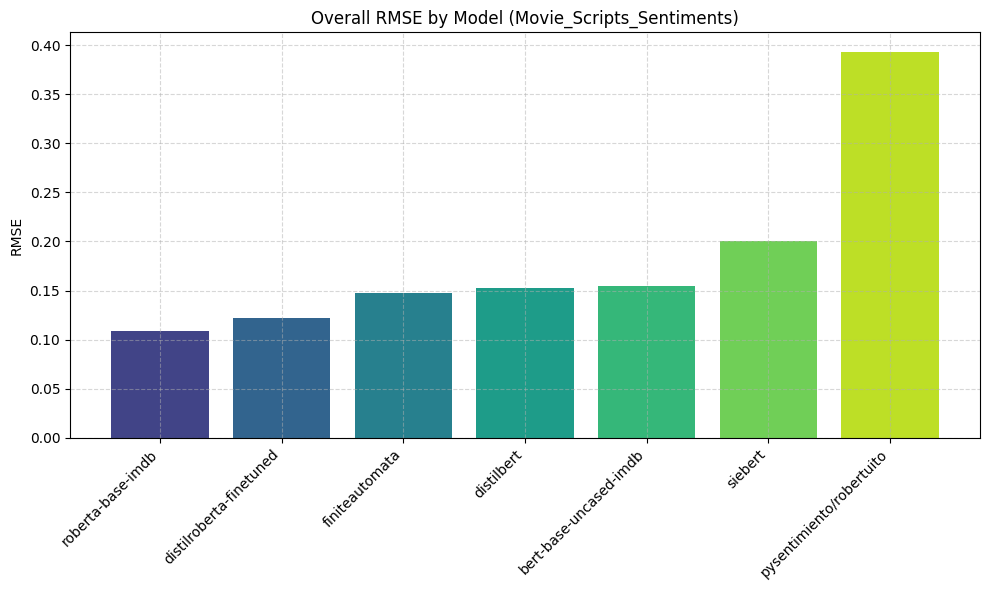

In [8]:

import matplotlib.pyplot as plt
import numpy as np


updated_models = [
    'siebert',
    'distilbert',
    'bert-base-uncased-imdb',
    'roberta-base-imdb',
    'finiteautomata',
    'pysentimiento/robertuito',
    'distilroberta-finetuned'
]
updated_rmse = [
    0.20047437855128455,
    0.15237309715171976,
    0.15441122427593668,
    0.10878250458240935,
    0.1478158092178248,
    0.3934287508046105,
    0.1216681764666476
]


sorted_indices = np.argsort(updated_rmse)
sorted_models = [updated_models[i] for i in sorted_indices]
sorted_rmse = [updated_rmse[i] for i in sorted_indices]


colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(updated_models)))


plt.figure(figsize=(10, 6))
plt.bar(sorted_models, sorted_rmse, color=colors)
plt.title('Overall RMSE by Model (Movie_Scripts_Sentiments)')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()

svg_output_path

In [6]:

sentiment_pipes = {n: pipeline("sentiment-analysis", model=n, device=0)
                   for n in model_names}

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Some weights of the model checkpoint at textattack/roberta-base-imdb were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [16]:
def to_score(res):
    label = res["label"].upper()
    score =  res["score"]
    if label in ("POSITIVE", "LABEL_1", "POS"):  return  score
    if label in ("NEGATIVE", "LABEL_0", "NEG"):  return -score
    return 0.0 

In [ ]:
rmse_per_model = {m: [] for m in model_names}

In [ ]:
csv_files = glob.glob(os.path.join(csv_folder, "*_subtitle.csv"))
total = len(csv_files)
print(f"Found {len(csv_files)} subtitle CSV files.")
for idx, path in enumerate(csv_files, 1):
    # 打印进度
    print(f"\n👉 [{idx}/{total}] Processing: {os.path.basename(path)}")
    df = pd.read_csv(path, encoding="utf‑8")
    if "Sentence" not in df.columns:
        print("⚠️  No 'Sentence' column -> skip", path);  continue
    if "Index"   not in df.columns:
        df = df.reset_index().rename(columns={"index": "Index"})

    for model_name, sa in sentiment_pipes.items():
        short = model_name.split("/")[-1]
        raw_col = f"score_{short}"
        sma_col = f"sma_{short}"
        try:
            preds  = sa(df["Sentence"].tolist(),
                         batch_size=16, truncation=True,
                         padding=True, max_length=128)
        except Exception as e:
            print(f"Error with model {short}: {e}");  continue

        df[raw_col] = [to_score(p) for p in preds]
        win = max(1, int(0.10*len(df)))          
        df[sma_col] = df[raw_col].rolling(win, center=True, min_periods=1).mean()

    
    sma_cols = [c for c in df.columns if c.startswith("sma_")]
    if not sma_cols:
        print("⚠️  No smooth columns for", path);  continue

    df["consensus_mean"] = df[sma_cols].mean(axis=1)
    frac = 0.02
    df["consensus_lowess"] = lowess(df["consensus_mean"],
                                    df["Index"], frac=frac)[:,1]
    consensus = df["consensus_lowess"].values


    for model_name in model_names:
        short = model_name.split("/")[-1]
        col   = f"sma_{short}"
        if col not in df.columns:      
            continue

        mse  = mean_squared_error(consensus, df[col])   
        rmse = sqrt(mse)
        rmse_per_model[model_name].append(rmse)

Found 300 subtitle CSV files.

👉 [1/300] Processing: 200_Meters_subtitle.csv


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



👉 [2/300] Processing: 24_Hours_to_Live_subtitle.csv

👉 [3/300] Processing: 365_Days_subtitle.csv

👉 [4/300] Processing: 365_Days__This_Day_subtitle.csv

👉 [5/300] Processing: 7500_subtitle.csv

👉 [6/300] Processing: 7_Guardians_of_the_Tomb_subtitle.csv

👉 [7/300] Processing: About_Dry_Grasses_subtitle.csv

👉 [8/300] Processing: About_Elly_subtitle.csv

👉 [9/300] Processing: Abraham_s_Valley_subtitle.csv

👉 [10/300] Processing: Acts_of_Vengeance_subtitle.csv

👉 [11/300] Processing: Adrift_subtitle.csv

👉 [12/300] Processing: After_the_Dark_subtitle.csv

👉 [13/300] Processing: Against_the_Ice_subtitle.csv

👉 [14/300] Processing: Agnee_subtitle.csv

👉 [15/300] Processing: Air_Force_The_Movie__Danger_Close_subtitle.csv

👉 [16/300] Processing: Alice_subtitle.csv

👉 [17/300] Processing: All_Quiet_on_the_Western_Front_subtitle.csv

👉 [18/300] Processing: Amaran_subtitle.csv

👉 [19/300] Processing: American_Ultra_subtitle.csv

👉 [20/300] Processing: Amour_subtitle.csv

👉 [21/300] Processing: 

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),



👉 [32/300] Processing: A_Greyhound_of_a_Girl_subtitle.csv

👉 [33/300] Processing: A_Separation_subtitle.csv

👉 [34/300] Processing: A_Serbian_Film_subtitle.csv

👉 [35/300] Processing: A_Simple_Favor_subtitle.csv

👉 [36/300] Processing: Bait_subtitle.csv

👉 [37/300] Processing: Baksa_Badal_subtitle.csv

👉 [38/300] Processing: Battleship_Potemkin_subtitle.csv

👉 [39/300] Processing: Below_Her_Mouth_subtitle.csv

👉 [40/300] Processing: Benedetta_subtitle.csv

👉 [41/300] Processing: Better_Man_subtitle.csv

👉 [42/300] Processing: Beyond_Skyline_subtitle.csv

👉 [43/300] Processing: Big_Bad_Wolves_subtitle.csv

👉 [44/300] Processing: Big_Game_subtitle.csv

👉 [45/300] Processing: Blackbird_Blackbird_Blackberry_subtitle.csv

👉 [46/300] Processing: Black_Book_subtitle.csv

👉 [47/300] Processing: Blood_Tide_subtitle.csv

👉 [48/300] Processing: Bridget_Jones__Mad_About_the_Boy_subtitle.csv

👉 [49/300] Processing: Brimstone_subtitle.csv

👉 [50/300] Processing: Bring_Them_Down_subtitle.csv

👉 [51/

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),



👉 [53/300] Processing: Cairo_Station_subtitle.csv

👉 [54/300] Processing: Calculator_subtitle.csv

👉 [55/300] Processing: Caligula_subtitle.csv

👉 [56/300] Processing: Captain_America__Brave_New_World_subtitle.csv

👉 [57/300] Processing: Chalet_Girl_subtitle.csv

👉 [58/300] Processing: Charlie_Countryman_subtitle.csv

👉 [59/300] Processing: Chasing_the_Wind_subtitle.csv

👉 [60/300] Processing: Chernobyl__Abyss_subtitle.csv

👉 [61/300] Processing: Chotushkone_subtitle.csv

👉 [62/300] Processing: Chungking_Express_subtitle.csv

👉 [63/300] Processing: Cirkus_Columbia_subtitle.csv

👉 [64/300] Processing: City_of_God_subtitle.csv

👉 [65/300] Processing: Cleaners_subtitle.csv

👉 [66/300] Processing: Cleaner_subtitle.csv

👉 [67/300] Processing: Close_subtitle.csv


c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),



👉 [68/300] Processing: Come_and_See_subtitle.csv

👉 [69/300] Processing: Contagion_subtitle.csv

👉 [70/300] Processing: Counterattack_subtitle.csv

👉 [71/300] Processing: Creation_of_the_Gods_I__Kingdom_of_Storms_subtitle.csv

👉 [72/300] Processing: Crossing_subtitle.csv

👉 [73/300] Processing: Crouching_Tiger__Hidden_Dragon_subtitle.csv

👉 [74/300] Processing: Cuckoo_subtitle.csv

👉 [75/300] Processing: Dara_of_Jasenovac_subtitle.csv

👉 [76/300] Processing: Dark_Waters_subtitle.csv

👉 [77/300] Processing: Dear_Ex_subtitle.csv

👉 [78/300] Processing: Dilwale_Dulhania_Le_Jayenge_subtitle.csv

👉 [79/300] Processing: Dogman_subtitle.csv

👉 [80/300] Processing: Dogtooth_subtitle.csv

👉 [81/300] Processing: Dog_Soldiers_subtitle.csv

👉 [82/300] Processing: Donbass_subtitle.csv

👉 [83/300] Processing: Doom_subtitle.csv

👉 [84/300] Processing: Dragonkeeper_subtitle.csv

👉 [85/300] Processing: Dredd_subtitle.csv

👉 [86/300] Processing: Drift_subtitle.csv

👉 [87/300] Processing: El_Conde_subti

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),



👉 [97/300] Processing: Furiosa__A_Mad_Max_Saga_subtitle.csv

👉 [98/300] Processing: Ghost_in_the_Shell_subtitle.csv

👉 [99/300] Processing: Ghost_Rider__Spirit_of_Vengeance_subtitle.csv

👉 [100/300] Processing: Gloria_Bell_subtitle.csv

👉 [101/300] Processing: Going_Steady_subtitle.csv

👉 [102/300] Processing: GomBurZa_subtitle.csv

👉 [103/300] Processing: Goodnight_Mommy_subtitle.csv

👉 [104/300] Processing: Guang_subtitle.csv

👉 [105/300] Processing: Handling_the_Undead_subtitle.csv

👉 [106/300] Processing: Hansel___Gretel__Witch_Hunters_subtitle.csv

👉 [107/300] Processing: Hardcore_Henry_subtitle.csv

👉 [108/300] Processing: Hatching_subtitle.csv

👉 [109/300] Processing: Hawa_subtitle.csv

👉 [110/300] Processing: Headshot_subtitle.csv

👉 [111/300] Processing: Hellhound_subtitle.csv

👉 [112/300] Processing: Hell_River_subtitle.csv

👉 [113/300] Processing: Hotel_Mumbai_subtitle.csv

👉 [114/300] Processing: Hotel_Rwanda_subtitle.csv

👉 [115/300] Processing: How_to_Make_Millions_Befor

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),



👉 [277/300] Processing: The_White_Tiger_subtitle.csv

👉 [278/300] Processing: The_World_Is_Big_and_Salvation_Lurks_Around_the_Corner_subtitle.csv

👉 [279/300] Processing: Three_Colors__Blue_subtitle.csv

👉 [280/300] Processing: Through_My_Window_subtitle.csv

👉 [281/300] Processing: Tiger_Stripes_subtitle.csv

👉 [282/300] Processing: Touch_subtitle.csv

👉 [283/300] Processing: To_a_Land_Unknown_subtitle.csv

👉 [284/300] Processing: Trauma_subtitle.csv

👉 [285/300] Processing: Triangle_of_Sadness_subtitle.csv

👉 [286/300] Processing: Troll_subtitle.csv

👉 [287/300] Processing: Twilight_of_the_Warriors__Walled_In_subtitle.csv

👉 [288/300] Processing: Underdogs_subtitle.csv

👉 [289/300] Processing: Underground_subtitle.csv

👉 [290/300] Processing: Urban_Legend_subtitle.csv

👉 [291/300] Processing: Wajib_subtitle.csv

👉 [292/300] Processing: Well_Tempered_Corpses_subtitle.csv

👉 [293/300] Processing: When_Evil_Lurks_subtitle.csv

👉 [294/300] Processing: Who_s_Singin__Over_There__subtitle.

In [ ]:
overall = {m: np.mean(vals) for m, vals in rmse_per_model.items()
           if vals}                        
ranking = sorted(overall.items(), key=lambda x: x[1])

print("\n========== Average RMSE over all movies ==========")
for rank, (m, r) in enumerate(ranking, 1):
    print(f"{rank:2d}. {m:60s}  RMSE = {r:.4f}")


pd.Series(overall, name="RMSE").to_csv("model_rmse_summary.csv")
print("Saved summary → model_rmse_summary.csv")


========== Average RMSE over all movies ==========
 1. pysentimiento/robertuito-sentiment-analysis                   RMSE = 0.1088
 2. mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis  RMSE = 0.1217
 3. finiteautomata/bertweet-base-sentiment-analysis               RMSE = 0.1478
 4. distilbert-base-uncased-finetuned-sst-2-english               RMSE = 0.1524
 5. textattack/bert-base-uncased-imdb                             RMSE = 0.1544
 6. siebert/sentiment-roberta-large-english                       RMSE = 0.2005
 7. textattack/roberta-base-imdb                                  RMSE = 0.3934
Saved summary → model_rmse_summary.csv
